# Twitter Setiment Analysis 

### Imports

In [1]:
# Basic Imports
import tweepy
import pandas as pd     
import numpy as np 
import time
import os
import re

# Plotting and Visualization
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
%matplotlib inline

# TextBlob Imports
from textblob import TextBlob
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier

# NLTK Imports
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

#MAP
from geopy.geocoders import Nominatim
import folium
from folium import plugins
from geopy.geocoders import Nominatim

### Twitter Autentication Keys

In [2]:
#Keys for autentication
consumer_key=''
consumer_secret=''

access_token=''
access_token_secret=''

### Twitter Autentication

In [3]:
#Autentication Methods
auth = tweepy.OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_token_secret)
api = tweepy.API(auth)

### Searching for Tweets

In [4]:
#Searchin Twitter Timelines
tweets = []
info = []

for tweet in tweepy.Cursor(api.search,
                           q="lula bolsonaro",
                           tweet_mode='extended',
                           rpp=100,
                           result_type="popular",
                           include_entities=True,
                           lang="pt").items(1500):
    if 'retweeted_status' in dir(tweet):
        aux=tweet.retweeted_status.full_text
    else:
        aux=tweet.full_text
        
    newtweet = aux.replace("\n", " ")
   
    tweets.append(newtweet)
    info.append(tweet)
    
    file = open("lula-bolsonaro.txt", "a", -1, "utf-8")
    file.write(newtweet+'\n')
    file.close()
    
    time.sleep(0.5)

### Creating the dataframe 

In [5]:
#Construction of the dataframe
tweets_df = pd.DataFrame(tweets, columns=['Tweets']) 

tweets_df['len']  = np.array([len(tweet) for tweet in tweets])
tweets_df['ID']   = np.array([tweet.id for tweet in info])
tweets_df['Date'] = np.array([tweet.created_at for tweet in info])
tweets_df['Source'] = np.array([tweet.source for tweet in info])
tweets_df['Likes']  = np.array([tweet.favorite_count for tweet in info])
tweets_df['RTs']    = np.array([tweet.retweet_count for tweet in info])
tweets_df['User Location']    = np.array([tweet.user.location for tweet in info])
tweets_df['Geo']    = np.array([tweet.geo for tweet in info])
tweets_df['Coordinates']    = np.array([tweet.coordinates for tweet in info])

tweets_df.to_csv("lula-bolsonaro.csv")

In [6]:
tweets_df.head()

,Tweets,len,ID,Date,Source,Likes,RTs,User Location,Geo,Coordinates
0,A mudança do país que culminou com eleição de ...,274,1076667402346221568,2018-12-23 02:34:46,Twitter for iPhone,3855,702,Paraná/Brasil,None,None
1,VÍDEO: “Quem votou no Bolsonaro que cobre ele....,106,1076766217220882433,2018-12-23 09:07:26,Twitter Web Client,575,181,"Sao Paulo, Brazil",None,None
2,"Com Lula, o Brasil reassumiu sua soberania e p...",181,1076891824684453888,2018-12-23 17:26:33,Twitter Web Client,866,229,,None,None
3,"De 2003 até o golpe de 2016, o Brasil foi prot...",185,1076877593738133504,2018-12-23 16:30:00,TweetDeck,474,181,Brasília / Brasil,None,None
4,Quem mandou Adélio esfaquear Bolsonaro? Ele ag...,116,1076477470453522432,2018-12-22 14:00:03,Twitter for Android,363,99,Brasília - Brasil,None,None


### Top Tweets

In [7]:
# Top Searched Tweets
fav_max = np.max(tweets_df['Likes'])
rt_max  = np.max(tweets_df['RTs'])

fav = tweets_df[tweets_df.Likes == fav_max].index[0]
rt  = tweets_df[tweets_df.RTs == rt_max].index[0]

# Max FAVs:
print("O tweet com mais curtidas é: \n{}".format(tweets_df['Tweets'][fav]))
print("Número de curtidas: {}".format(fav_max))
print("\n")
# Max RTs:
print("O tweet com mais retweet é: \n{}".format(tweets_df['Tweets'][rt]))
print("Número de retweets: {}".format(rt_max))

O tweet com mais curtidas é: 
Lula livre não é bom pra ninguém. Lula vai continuar sendo o condenado desacreditado, preso em casa.  Bolsonaro ganha uma pauta nova que nao é o Queiroz. MBL ja tá alvoroçando o país pra protestar e capitalizar o antipetismo. STF perde os pontinhos que tinha com a opinião pública
Número de curtidas: 11901


O tweet com mais retweet é: 
Sabem quem não apareceu pra depor hoje conforme marcado? Ele mesmo, o assessor-amigão do clã Bolsonaro, o Queiroz! Alegou uma "crise inesperada de saúde".  Mas os que "não têm corrupto de estimação" estão caladinhos. Ou melhor: estão, como de costume, gritando sobre o Lula.
Número de retweets: 2323


### Source of Tweets

In [8]:
#Source of the Tweets
sources = []
for source in tweets_df['Source']:
    if source not in sources:
        sources.append(source)

percent = np.zeros(len(sources))

for source in tweets_df['Source']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass

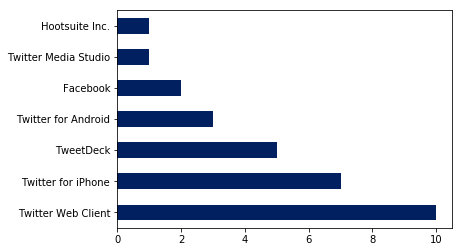

In [9]:
newDF = pd.DataFrame({
 'source':percent,
}, index=sources)

sources_sorted = newDF.sort_values('source',ascending=False)
ax = sources_sorted.source.plot(kind='barh',color='#002060')
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

### Training Model

In [10]:
#Sentiment Analysis in Português and English

base_path = 'c:/ReLi-Lex'
train = []
wordsPT = []
wordsPT_sentiments = []

files = [os.path.join(base_path, f) for f in os.listdir(base_path)]

for file in files:
    t = 1 if '_Positivos' in file else -1
    with open(file, 'r') as content_file:
        content = content_file.read()
        all = re.findall('\[.*?\]',content)
        for w in all:
            wordsPT.append((w[1:-1]))
            wordsPT_sentiments.append(t)
            train.append((w[1:-1], t))

cl = NaiveBayesClassifier(train)

In [11]:
def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

### Sentiment Analysis with TextBlob

In [12]:
def sentiment(tweet):
    
    polarity = 0
    
    #blob = TextBlob(tweet, classifier=cl)
    blob = TextBlob(clean_tweet(tweet), classifier=cl) #Clean Tweets
    
    for s in blob.sentences:
        polarity = s.classify() + polarity
    
    if polarity > 0:
        return 1
    elif polarity < 0:
        return -1
    else:
        return 0

In [13]:
def analize_sentimentEN(tweet):
    
    analysis = TextBlob(tweet)
    
    if analysis.detect_language() != 'en':
        analysis = TextBlob(str(analysis.translate(to='en')))
        time.sleep(0.5)    
        
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [600]:
#tweets_df['SA'] = np.array([ analize_sentimentEN(tweet) for tweet in tweets_df['Tweet'] ]) #English Dictionary

In [14]:
tweets_df['SA TextBlob'] = np.array([ sentiment(tweet) for tweet in tweets_df['Tweets'] ]) #Portuguese Dictionary

### Results of Sentiment Analysis

In [15]:
#Sentiment Analysis Results
pos_tweets = [ tweet for index, tweet in enumerate(tweets_df['Tweets']) if tweets_df['SA TextBlob'][index] > 0]
neg_tweets = [ tweet for index, tweet in enumerate(tweets_df['Tweets']) if tweets_df['SA TextBlob'][index] < 0]

In [16]:
print("Porcentagem de Tweets Positivos: {}%".format(len(pos_tweets)*100/len(tweets_df['Tweets'])))
print("Porcentagem de Tweets Negativos: {}%".format(len(neg_tweets)*100/len(tweets_df['Tweets'])))

Porcentagem de Tweets Positivos: 79.3103448275862%
Porcentagem de Tweets Negativos: 20.689655172413794%


In [17]:
sentiments = ['Positivos', 'Negativos']
percents = [len(pos_tweets), len(neg_tweets)]

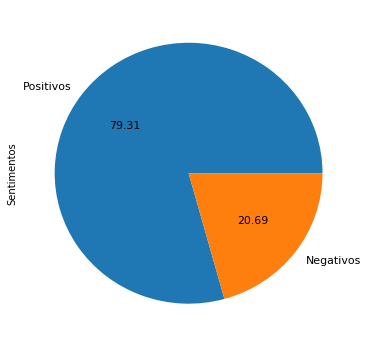

In [18]:
pie_chart = pd.Series(percents, index=sentiments, name='Sentimentos')
pie_chart.plot.pie(fontsize=11, autopct='%.2f', figsize=(6, 6));

### Word Cloud

In [19]:
stopwords= set(STOPWORDS)

new_words = []
with open("stopwords_portuguese.txt", 'r') as f:
    [new_words.append(word) for line in f for word in line.split()]

new_stopwords = stopwords.union(new_words)

In [20]:
words = ' '.join(tweets_df['Tweets'])

words_clean = " ".join([word for word in words.split()
                            if 'https' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

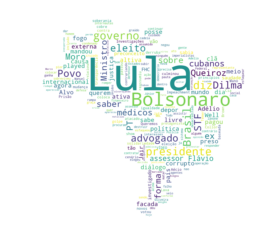

In [21]:
from imageio import imread
import warnings

warnings.simplefilter('ignore')

twitter_mask = imread('brasil_mask.png')

wc = WordCloud(min_font_size=10, 
               max_font_size=300, 
               background_color='white', 
               mode="RGB",
               stopwords=new_stopwords,
               width=2000, 
               height=1000,
               mask=twitter_mask,
               normalize_plurals= True).generate(words_clean)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig('lula-bolsonaro.png', dpi=300)
plt.show()

### Time Series

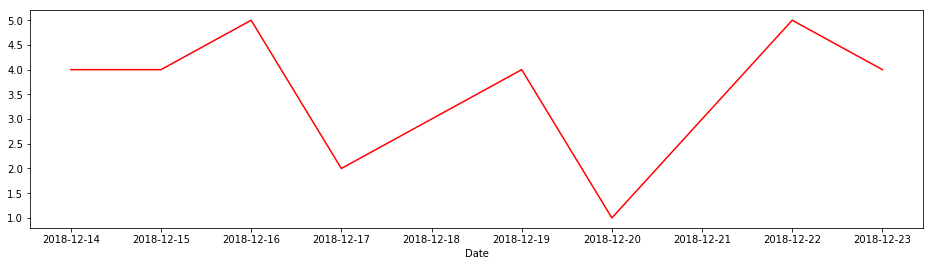

In [22]:
#Tweets per Day
data = tweets_df

data['Date'] = pd.to_datetime(data['Date']).apply(lambda x: x.date())

tlen = pd.Series(data['Date'].value_counts(), index=data['Date'])
tlen.plot(figsize=(16,4), color='r');

# Twitter Setiments Analisys with NLTK

### Training Model

In [23]:
vectorizer = CountVectorizer(analyzer="word")
freq_tweets = vectorizer.fit_transform(wordsPT)
modelo = MultinomialNB()
modelo.fit(freq_tweets,wordsPT_sentiments);

### Sentiment Analisys

In [24]:
tweetsarray = []

for tw in tweets_df['Tweets']:
    text = clean_tweet(tw)
    tweetsarray.append(text)

In [25]:
predictionData = vectorizer.transform(tweets_df['Tweets'])
tweets_df['SA NLTK'] = modelo.predict(predictionData)

### Results of Sentiment Analysis

In [26]:
#Sentiment Analysis Results
pos_tweets = [ tweet for index, tweet in enumerate(tweets_df['Tweets']) if tweets_df['SA NLTK'][index] > 0]
neg_tweets = [ tweet for index, tweet in enumerate(tweets_df['Tweets']) if tweets_df['SA NLTK'][index] < 0]

In [27]:
print("Porcentagem de Tweets Positivos: {}%".format(len(pos_tweets)*100/len(tweets_df['Tweets'])))
print("Porcentagem de Tweets Negativos: {}%".format(len(neg_tweets)*100/len(tweets_df['Tweets'])))

Porcentagem de Tweets Positivos: 86.20689655172414%
Porcentagem de Tweets Negativos: 13.793103448275861%


In [28]:
sentiments = ['Positivos', 'Negativos']
percents = [len(pos_tweets), len(neg_tweets)]

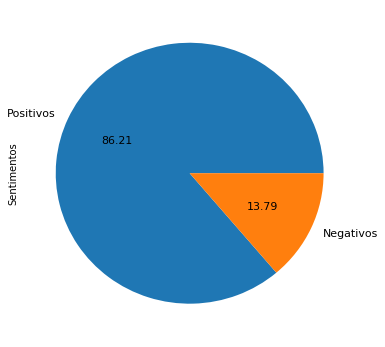

In [29]:
pie_chart = pd.Series(percents, index=sentiments, name='Sentimentos')
pie_chart.plot.pie(fontsize=11, autopct='%.2f', figsize=(6, 6));

### Map of Tweets

In [30]:
geolocator = Nominatim(user_agent="TweeterSentiments")

latitude = []
longitude = []

for user_location in tweets_df['User Location']:
    try:
        location = geolocator.geocode(user_location)
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    except:
        continue

In [31]:
coordenadas = np.column_stack((latitude, longitude))

mapa = folium.Map(location=[-15.788497,-47.879873],zoom_start=4.)

mapa.add_child(plugins.HeatMap(coordenadas))
mapa.save('lula-bolsonaro.html')
mapa